In [1]:
import numpy as np
import time
import math
import modules as md
#import nbodysolver as nbs
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import matplotlib.patches as mpatches



#------------------------------------------------------------------------------------------
#Units and conversions:
#------------------------------------------------------------------------------------------
#code units: Rsun, Msun, G=1, ...
c_SI       = 299792458.0        #m/s
M_sun_SI   = 1.989*(10.**30.)   #kg
R_sun_SI   = 695800000.         #m
R_bull_SI = 1000 #m 
AU_SI      = 149597871000.      #m 
G_new_SI   = 6.67*(10.**(-11.)) #m**3 kg**(-1) s**(-2)
AU_U       = AU_SI/R_sun_SI                             #from dist AU to code units (U)
kmsec_U    = 1000./np.sqrt(G_new_SI*M_sun_SI/R_bull_SI)  #from vel km/sec to code units (U)
time_U     = 1/np.sqrt(G_new_SI*M_sun_SI/R_bull_SI**3) #from CU to second np.sqrt((R_bull_SI)/(G_new_SI*M_sun_SI)) #from code units(U) to time sec
#Rsch_1Msun_unitRsun = ((2.*G_new_SI*(1.*M_sun_SI))/(c_SI**2.))/R_sun_SI
c_CU = c_SI/1000*kmsec_U

# Newtonian  

In [2]:
#Acceleration

def acc(r,m): #r position, m mass
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = (rrel**2).sum()**(1./2) 
                a[i] += -(rrel)*m[j]/(rn**3.0) #Acceleration at each time step 
    return a # return acceleration


def Jerk(r,v,m): #position, velocity, mass
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = (rrel**2).sum()**(1./2) # dot product
                vn = (vrel**2).sum()**(1./2)
                rvd = ((rrel)*(vrel)).sum()
                Je[i] += - m[j]*((vrel)/rn**3.0 - 3.*(rvd*rrel/(rn**5.0))) 
    return Je;

# Spin 

In [4]:
def accspin(r,m,ns,S):#r,m,S,ns #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = rrel/rn
                Sn = ((S[i]*S[i]).sum())**(1./2)
                a[i] += -(3./2)*ns[i]*(m[j]*Sn**2/m[i])*(runi)/(rn**4.0) #Acceleration at each time step
                
    return a # return acceleration

def Jerkspin(r,v,m, ns,S):#r,v,m,S,ns #r position, v velocity, m mass, m mass of the star, ne
    Je = np.zeros((len(r),3)) #Define the Jerk
    Je1 = np.zeros((len(r),3))
    Je2 = np.zeros((len(r),3))
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = (r[i]-r[j])
                vrel = (v[i]-v[j])
                rn = ((rrel**2).sum())**(1./2) # dot product
                Sn = ((S[i]*S[i]).sum())**(1./2)
                #Je1[i] += - (3./2)*ns[i]*((m[j])/m[i])*(2*((S*b).sum())*rrel/r**5 ) #Still need to define b 
                Je2[i] += - (3./2)*ns[i]*((m[j])/m[i])*(Sn**2)*(vrel/rn**5.0 - 5.*((vrel*rrel).sum())*(rrel)/(rn**7.0))               
                Je[i] += Je2[i] #Je1[i] + Je2[i] 
    return Je;

def bccspin(r,v,m,eta,S,I): #r position, m mass, s spin, m mass of the star
    b = np.zeros((len(r),3)) #Create acceleration vector
    b1 = np.zeros((len(r),3))
    b2 = np.zeros((len(r),3))
    #bden = np.zeros((len(r),3))
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                #if([i] == 0.0):
                #    b[i] = np.array([0,0,0])
                #elif (ns[i] != 0):
                rrel = r[i]-r[j]
                rn = ((rrel**2).sum())*(1./2)
                runi = 1.*rrel/rn
                vrel = v[i] - v[j]
                rdv = (rrel*vrel).sum()
                Sn = ((S[i]*S[i]).sum())**(1./2)
                #bden[i] = I[i] #(I[i] + m[j]*ns[i]/rn**3)
                acorr = 0 #m[j]*ns[i]/rn**3 because ns = 0 for bhs 
                if I[i] != 0:
                    b1[i] += (1/(I[i]+acorr))*(9*eta[i]*(m[j]**2))*( np.cross(runi,vrel) - rn*S[i])*(1./(rn**7.0))
                    #b2[i] += 
                elif I[i] == 0:
                    b1[i] += 0
                b[i] = b1[i] #b1[i] #+ b2[i]
    return b # return acceleration

# PN 

In [5]:
#PN Acceleration
def accPN(r,v,m): #r position, m mass, s spin, m mass of secondary
    a = np.zeros((len(r),3)) #Create acceleration vector
    a1 = np.zeros((len(r),3)) #Create acceleration vector
    a2 = np.zeros((len(r),3)) #Create acceleration vector

    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle           
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                rn = ((rrel**2).sum())**(1./2) #norm
                runi = 1.*rrel/rn
                #rvd = ((rrel)*(vrel)).sum()
                ruvd = ((runi)*(vrel)).sum() #dot product
                v2d = (vrel**2).sum()
                a1[i] += +(4./5)*(1./c_CU**5)*(m[i]*m[j]/(rn**3))*((2*m[i]/rn - 8*m[j]/rn - v2d)*vrel) #Need to divide by m[i]
                a2[i] += +(4./5)*(1./c_CU**5)*(m[i]*m[j]/(rn**3))*(runi*ruvd*(52.0*m[j]/(3*rn) - 6*m[i]/rn + 3.0*v2d)) #Need to divide by m[i]
                a[i] += a1[i] + a2[i] #a1[i] +  
    return a#, a1, a2 # return acceleration


#PN Jerk v2

def JerkPN(r,v,a,m): #position, velocity, mass
    JePNLO3 = np.zeros((len(r),3))
    JePNLO3v2 = np.zeros((len(r),3))
    JePNLO4 = np.zeros((len(r),3))
    JePNLO5 = np.zeros((len(r),3))#Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                arel = a[i]-a[j]
                rn = ((rrel**2).sum())**(1./2) #norm                                                    
                vn = ((vrel**2).sum())**(1./2) 
                runi = 1.*rrel/rn
                ruvd = (runi*vrel).sum()   
                ruad = (runi*arel).sum()                                                  
                vad = (vrel*arel).sum()
                JePNLO3[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**3))*(-(vn**2)*arel + 2*vad*vrel + 3*((ruvd*(vn**2)*vrel) + 2*( vad*ruvd + (vn**2)*ruad)*runi))                
                JePNLO4[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**4))*(3*ruvd*(vn**2)*vrel + 2*(m[i]-m[j])*arel+ 3*(vn**4)*runi - 15*(ruvd**2)*(vn**2)*runi + ((52./3)*m[j]-6*m[i])*(ruad)*runi)
                JePNLO5[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**5))*(-8*(m[i] - m[j])*(ruvd)*vrel + ((52./3)*m[j]-6*m[i])*((vn**2)*runi + ruvd*vrel - 6*((ruvd**2)*runi)))
                JePNLOt = JePNLO3 + JePNLO4 + JePNLO5 
    return JePNLOt 

# Dissipative

In [12]:
def accdissS(r,v,m,eta, S): #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3)) #Create acceleration vector
    a1 = np.zeros((len(r),3)) #Create acceleration vector
    a2 = np.zeros((len(r),3)) #Create acceleration vector
    a3 = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = rrel/rn
                a1[i] += -(9.)*eta[i]*((m[j]**2)/m[i])*(vrel)/(rn**8.0) #Acceleration at each time step    
                a2[i] += -(18.)*eta[i]*((m[j]**2)/m[i])*(runi*((runi*vrel).sum()))/(rn**8.0)
                a3[i] += -(9.)*eta[i]*((m[j]**2)/m[i])*( np.cross(rrel, S[i]))/(rn**8.0)
                a[i] = a1[i] + a2[i] + a3[i] 
                #This is the term that becomes zero in a circular orbit
                #a[i,:] += -(18.)*ne[i]*((m[j]**2)/m[i])*(runi)*((runi*vrel).sum())/(rn**8.0) #Acceleration at each time step 
    return a # return acceleration


def Jerkdiss(r,v,a,m, ne): #r position, v velocity, m mass, m mass of the star, ne
    Je = np.zeros((len(r),3)) #Define the Jerk
    Je1 = np.zeros((len(r),3)) #Define the Jerk
    Je2 = np.zeros((len(r),3)) #Define the Jerk

    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = (r[i]-r[j])
                vrel = (v[i]-v[j])
                arel = (a[i]-a[j])
                rn = ((rrel**2).sum())**(1./2) # dot product
                vn = ((vrel**2).sum())**(1./2)
                Je1[i] += - (9.0)*ne[i]*((m[j]**2)/m[i])*( arel/rn**8.0 - 8.*((vrel*rrel).sum())*(vrel)/(rn**10.0) )                 
                Je2[i] += - (18.0)*ne[i]*((m[j]**2)/m[i])*((arel*((rrel*vrel).sum()) + rrel*((rrel*arel).sum() + vn**2))/(rn**10.0) - (10*rrel*(((rrel*vrel).sum())**2))/(rn**12.0))
                Je[i] = Je1[i] + Je2[i]
    return Je;


# PN + Spin + Dissipation Integrator 

In [13]:
def HermiteUpdatePNSDdt(dt, r, v, m, ns, S,I, eta): # m mass of the star
    
    aN = acc(r, m) 
    aS = accspin(r, m, ns, S)
    aPN = accPN(r, v, m)
    aD = accdissS(r, v, m, eta, S)
    a = aN + aS + aPN + aD        # current acceleration
    
    aNdot = Jerk(r,v,m)
    aSdot = Jerkspin(r, v, m, ns, S)
    aPNdot = JerkPN(r, v, a, m)
    aDdot = Jerkdiss(r, v, a, m, eta)
    adot = aNdot + aSdot + aPNdot + aDdot 
    
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aSp = accspin(rp, m, ns, S)
    aPNp = accPN(rp, vp, m)
    aDp = accdissS(rp, vp, m, eta, S)

    ap = aNp + aSp + aPNp + aDp         # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aSdotp = Jerkspin(rp, vp, m, ns, S)
    aPNdotp = JerkPN(rp, vp, ap, m)
    aDdotp = Jerkdiss(rp, vp, ap, m, eta)
    adotp = aNdotp + aSdotp + aPNdotp + aDdotp # predicted jerks 
    
    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + dt/2*(adotp + adot)
    aNc = aN + dt/2*(aNdotp + aNdot)
    aPNc = aPN + dt/2*(aPNdotp + aPNdot)
    
    #Spin
    
    b = bccspin(r,v,m,eta,S,I) #r,v,m,S,ns,I
    Sp = S + (dt*b) #+ ()*dt/2

    bp = bccspin(rp,vp,m,eta,Sp,I)
    Sc = S + (b + bp)*dt/2
    bc = b #+ ()*dt/2 Higher order terms
       
    #Sc = S
 
    return rc,vc,Sc, bc, ac, aNc, aPNc, dtp # ac, aNc,aPNc,


In [14]:
def Hermite4thPNSTdt(pri,sec, bina, nsteps,Dt):

    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))
    S_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    b_res = np.zeros((2,3,nsteps-1))

    aN_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))
    aPN_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies

    a_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    S_res[:,:,0] = bina.S.copy()
    
    nspinv = np.array([pri.nspin, sec.nspin])
    #ndtidev = np.array([pri.ndtide, sec.ndtide])
    Iv = np.array([pri.inertiam, sec.inertiam])
    etav = np.array([pri.eta, sec.eta])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i], v_res[:,:,i], S_res[:,:,i], b_res[:,:,i-1] , a_res[:,:,i-1], aN_res[:,:,i-1], aPN_res[:,:,i-1], dtp[i]) = HermiteUpdatePNSDdt(Dt, r_res[:,:,i-1], v_res[:,:,i-1],  m, nspinv, S_res[:,:,i-1], Iv,etav)
        #
        time[i] = time[i-1] + Dt#
        if time[i] >= timelimit:
            break
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(pri.radisch+sec.radisch): #This is when running an equal mass bbh
        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(pri.radisch+sec.radiplus): #This is when running an equal mass bbh

        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
            break
            
    r_res = r_res[:,:,:i+1]
    v_res = v_res[:,:,:i+1]
    a_res = a_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    aPN_res = aPN_res[:,:,:i]
    b_res = b_res[:,:,:i]
    S_res = S_res[:,:,:i+1]
    dtp = dtp[:i+1]
    time = time[:i+1]

    return r_res, v_res, S_res, b_res,a_res, aN_res, aPN_res, time #

In [15]:
# CHange stop simulation parameter to include spin

In [16]:
#Define black holes
bh = md.Particle("BH",20,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius

#Define binary
#bhbh = md.Binary(bh, bh, bh.radisch*10, 0) ##primary, secondary, orbital distance (Rsun), eccentricity 


In [23]:
Sd = np.array([0.1,0.2]) #Dimensionless spin

Sr = Sd*bh.mass/c_CU**2

Omega = c_CU*Sr/(bh.radisch**2)

bhspinarr = np.array([0,0,Omega[1]])


In [24]:
print(Omega)

[0.000697   0.00139399]


In [25]:
bhspin = md.Particle("BH",20,0,bhspinarr)

In [26]:
bhspin.inertiam

68323.36523102128

In [27]:
bhbhspin = md.Binary(bh, bhspin, bh.radisch*7, 0) ##primary, secondary, orbital distance (Rsun), eccentricity 


In [33]:
#Have implemented it, need to check it
timetomerge =  (5./256)*(bhbhspin.orbd**4)*(c_CU**5)*(1./(bh.mass*bh.mass*(bh.mass+bh.mass)))

print(timetomerge/bhbhspin.periodct)

#accu = 0.001 #0.0001 Set accuracy parameter
tl = 12*bhbhspin.periodct #Time of the simulation in [code units]
timelimit = tl #
dt = 0.005 #Guess a timestep
Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 

1.611963716253267


In [34]:
rPNSD, vPNSD, S_PNSD, b_PNSD,a_PNSD, aN_PNSD, aPN_PNSD, timePNSD  = Hermite4thPNSTdt(bh,bhspin, bhbhspin, Nsteps, dt)

In [35]:
print(timePNSD[-1]*time_U)

0.0386089866879857


In [89]:
print(timePNSD[-1]*time_U)

0.03860926123912039


In [45]:
print(timePNSD[-1])

14062.800000033629


In [29]:
print(timePNSD[-1])

14062.600000033628


In [249]:
print(S_PNSD)


[[[0.       0.       0.       ... 0.       0.       0.      ]
  [0.       0.       0.       ... 0.       0.       0.      ]
  [0.       0.       0.       ... 0.       0.       0.      ]]

 [[0.       0.       0.       ... 0.       0.       0.      ]
  [0.       0.       0.       ... 0.       0.       0.      ]
  [0.000697 0.000697 0.000697 ... 0.000697 0.000697 0.000697]]]


In [250]:
print(timePNSD[-1])

14062.700000033628


In [251]:
print(timePNSD[-1])

14062.700000033628


In [225]:
print(timePND[-1])

14062.500000033628


No handles with labels found to put in legend.


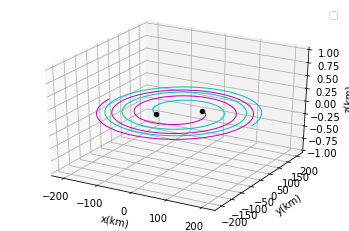

In [36]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rPNSD[0][0], rPNSD[0][1], rPNSD[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rPNSD[1][0], rPNSD[1][1], rPNSD[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rPNSD[0][0][-1], rPNSD[0][1][-1], rPNSD[0][2][-1], 'o', c='black') #s=100 markersize=40
ax.scatter3D(rPNSD[1][0][-1], rPNSD[1][1][-1], rPNSD[1][2][-1], 'o', c='black') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
ax.set_zlim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')


#plt.savefig('TPNcol.png', bbox_inches='tight', dpi=300)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', format='eps')#,

plt.show()

In [37]:
rrelPNSD = rPNSD[0] - rPNSD[1]
vrelPNSD = vPNSD[0] - vPNSD[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPNSD = np.zeros(len(rrelPNSD .T)) 

for i in range(len(rrelPNSD.T)):
    dPNSD[i] = np.linalg.norm(rrelPNSD.T[i])
    
#Obtain the relative velocity
vnrelPNSD = np.zeros(len(vrelPNSD.T))

for i in range(len(rrelPNSD.T)):
    vnrelPNSD[i] = np.linalg.norm(vrelPNSD.T[i])
    
vnrelPNSDkm = vnrelPNSD/kmsec_U*1000/c_SI
timePNSDsec = timePNSD*time_U

In [38]:
np.cross(rrelPNSD.T[0],S_PNSD[1].T[0] )

array([ 0.        , -0.57615381,  0.        ])

In [39]:
np.cross(rrelPNSD.T[-1],S_PNSD[1].T[-1] )

array([-0.10599799,  0.1259452 ,  0.        ])

In [40]:
print(vPNSD[1].T[-1])

[-0.25176485  0.13397093  0.        ]


In [310]:
np.linalg.norm(rrelPNSD.T[-1])

117.9224342358874

In [311]:
print(S_PNSD)

[[[0.       0.       0.       ... 0.       0.       0.      ]
  [0.       0.       0.       ... 0.       0.       0.      ]
  [0.       0.       0.       ... 0.       0.       0.      ]]

 [[0.       0.       0.       ... 0.       0.       0.      ]
  [0.       0.       0.       ... 0.       0.       0.      ]
  [0.000697 0.000697 0.000697 ... 0.000697 0.000697 0.000697]]]


In [312]:
rrelPNSD.T[0]

array([413.31126517,   0.        ,   0.        ])

In [313]:
vPNSD[1].T[0]

array([ 0.        , -0.15554691,  0.        ])

In [314]:
rrelPNSD.T[1000]

array([412.1413984,  31.0655861,   0.       ])

In [315]:
S_PNSD[1].T[0]

array([0.      , 0.      , 0.000697])

In [41]:
wsPNSD = np.zeros([len(dPNSD)])

for i in range(len(dPNSD)):
    wsPNSD[i] = ((bh.mass+bh.mass)/dPNSD[i]**3)**(1./2) 
    

hplusPNSD = np.zeros([len(dPNSD)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (bh.mass*bh.mass)/(bh.mass+bh.mass)

for i in range(len(dPNSD)):
    hplusPNSD[i] = (1./ro)*(4*mu*(wsPNSD[i]**2)*(dPNSD[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPNSD[i]*timePNSD[i])
    #hcrossPND[i] = (1./ro)*(4*mu*(wsPND[i]**2)*(dPND[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*wsPND[i]*timesimtp[i])

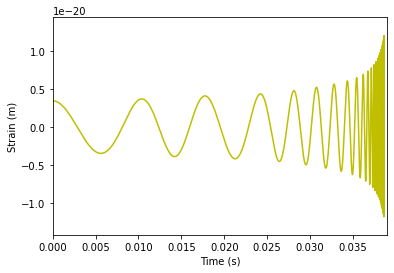

In [42]:
plt.plot(timePNSDsec, hplusPNSD, 'y-')
plt.axis([min(timePNSD), 1.01*max(timePNSDsec), 1.2*min(hplusPNSD), 1.2*max(hplusPNSD)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

# PN + Dissipation Integrator 

In [43]:
def accdiss(r,v,m,ne): #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3)) #Create acceleration vector
    a1 = np.zeros((len(r),3)) #Create acceleration vector
    a2 = np.zeros((len(r),3)) #Create acceleration vector
    #a3 = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = rrel/rn
                a1[i] += -(9.)*ne[i]*((m[j]**2)/m[i])*(vrel)/(rn**8.0) #Acceleration at each time step    
                a2[i] += -(18.)*ne[i]*((m[j]**2)/m[i])*(runi*((runi*vrel).sum()))/(rn**8.0)
                #a3[i] += spin part
                a[i] = a1[i] + a2[i] #+ a3[i] 
                #This is the term that becomes zero in a circular orbit
                #a[i,:] += -(18.)*ne[i]*((m[j]**2)/m[i])*(runi)*((runi*vrel).sum())/(rn**8.0) #Acceleration at each time step 
    return a # return acceleration

In [44]:
def HermiteUpdatePNdissdt(dt, r, v, m, ns): # m mass of the star
    
    aN = acc(r, m) 
    aD = accdiss(r, v, m, ns)
    aPN = accPN(r, v, m)
    a = aN + aPN + aD # current acceleration
    
    aNdot = Jerk(r,v,m)
    aDdot = Jerkdiss(r, v, a, m, ns)
    aPNdot = JerkPN(r, v, a, m)
    adot = aNdot + aPNdot + aDdot # current jerks
    
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aPNp = accPN(rp, vp, m)
    aDp = accdiss(rp, vp, m, ns)
    ap = aNp + aPNp + aDp        # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aPNdotp = JerkPN(rp, vp, ap, m)
    aDdotp = Jerkdiss(rp, vp, ap, m, ns)
    adotp = aNdotp + aPNdotp +  aDdotp  # predicted jerks 
    
    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + (adotp+adot)*dt/2
 
    return rc,vc,dtp #ap,adotp,aNp,aNdotp,

def Hermite4thPNdissdt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))

    aN_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adotN_res = np.zeros((2,3,nsteps))

    a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    etav = np.array([pri.eta, sec.eta])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i], dtp[i]) = HermiteUpdatePNdissdt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, etav)
        time[i] = time[i-1] + dtp[i-1] #+ Dt #
        if time[i] >= timelimit:
            break
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(pri.radisch+sec.radisch): #This is when running an equal mass bbh
        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
            break
    
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    a_res = a_res[:,:,:i]
    adot_res = adot_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    adotN_res = adotN_res[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
        
    return r_res, v_res, time #, aN_res, adotN_res, a_res, adot_res, 


In [45]:
bh = md.Particle("BH",20,0,0)
bhbh = md.Binary(bh,bh,bh.radisch*7,0)

In [46]:
#Have implemented it, need to check it
timetomerge =  (5./256)*(bhbh.orbd**4)*(c_CU**5)*(1./(bh.mass*bh.mass*(bh.mass+bh.mass)))

print(timetomerge/bhbh.periodct)

#accu = 0.001 #0.0001 Set accuracy parameter
tl = 12*bhbh.periodct #Time of the simulation in [code units]
timelimit = tl #
#dt = 0.01 #Guess a timestep
#test diss
dt= 0.005
Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 

1.611963716253267


In [47]:
rPND,vPND,timePND = Hermite4thPNdissdt(bh,bh, bhbh, Nsteps, dt)

In [48]:
timePND[-1]

14062.539999215898

No handles with labels found to put in legend.


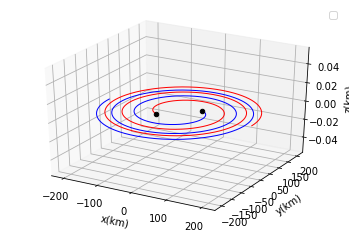

In [58]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rPND[0][0], rPND[0][1], rPND[0][2], 'r', linewidth=1)# Plot the BH orbit
ax.plot(rPND[1][0], rPND[1][1], rPND[1][2], 'b', linewidth=1)# Plot the star orbit
ax.scatter3D(rPND[0][0][-1], rPND[0][1][-1], rPND[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(rPND[1][0][-1], rPND[1][1][-1], rPND[1][2][-1], 'o', c='black') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')


#plt.savefig('PNorbitaldecay.png', format='png', dpi=200)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', format='eps')#,

plt.show()

In [50]:
rrelPND = rPND[0] - rPND[1]
vrelPND = vPND[0] - vPND[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPND = np.zeros(len(rrelPND .T)) 

for i in range(len(rrelPND.T)):
    dPND[i] = np.linalg.norm(rrelPND.T[i])
    
#Obtain the relative velocity
vnrelPND = np.zeros(len(vrelPND.T))

for i in range(len(rrelPND.T)):
    vnrelPND[i] = np.linalg.norm(vrelPND.T[i])
    
vnrelPNDkm = vnrelPND/kmsec_U*1000/c_SI
timePNDsec = timePND*time_U

In [51]:
wsPND = np.zeros([len(dPND)])

for i in range(len(dPND)):
    wsPND[i] = ((bh.mass+bh.mass)/dPND[i]**3)**(1./2) 
    

hplusPND = np.zeros([len(dPND)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (bh.mass*bh.mass)/(bh.mass+bh.mass)

for i in range(len(dPND)):
    hplusPND[i] = (1./ro)*(4*mu*(wsPND[i]**2)*(dPND[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPND[i]*timePND[i])
    #hcrossPND[i] = (1./ro)*(4*mu*(wsPND[i]**2)*(dPND[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*wsPND[i]*timesimtp[i])

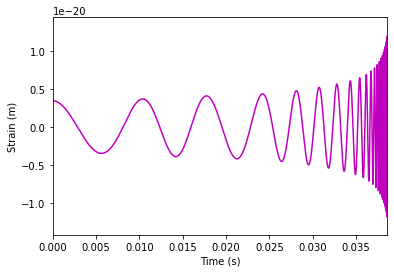

In [52]:
plt.plot(timePNDsec, hplusPND, 'm-')
plt.axis([min(timePND), max(timePNDsec), 1.2*min(hplusPND), 1.2*max(hplusPND)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

# Comparison of waveforms 

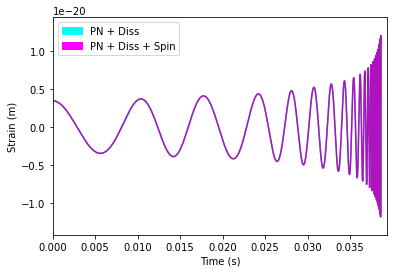

In [53]:
cyan_patch = mpatches.Patch(color='cyan', label=r'PN + Diss')
magenta_patch = mpatches.Patch(color='magenta', label=r'PN + Diss + Spin')
plt.legend(handles=[cyan_patch, magenta_patch])
plt.plot(timePNDsec, hplusPND, 'c-', alpha = 0.9)
plt.plot(timePNSDsec, hplusPNSD, 'm-', alpha = 0.9)
plt.axis([min(timePNDsec), 1.02*max(timePNDsec), 1.2*min(hplusPND), 1.2*max(hplusPND)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-TPNvsPN.eps', bbox_inches='tight') #, dpi=300
plt.show()

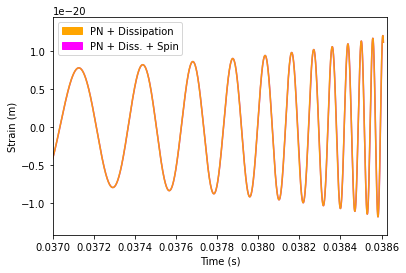

In [57]:
cyan_patch = mpatches.Patch(color='Orange', label=r'PN + Dissipation ')
magenta_patch = mpatches.Patch(color='magenta', label=r'PN + Diss. + Spin')
plt.legend(handles=[cyan_patch, magenta_patch])
plt.plot(timePNSDsec, hplusPNSD, 'm-', alpha = 0.9)
plt.plot(timePNDsec, hplusPND, '-', color='orange', alpha = 0.9)
plt.axis([0.0370, 1.0005*max(timePNSDsec), 1.2*min(hplusPNSD), 1.2*max(hplusPNSD)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-PNDSvsPND.eps', bbox_inches='tight') #, dpi=300
plt.show()

# Unequal mass case 

In [ ]:
#Define black holes
bh = md.Particle("BH",40,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
bh2 = md.Particle("BH", 20, 0, 0)

#Define binary
bhbh2 = md.Binary(bh2, bh, bh.radisch*8, 0) ##primary, secondary, orbital distance (Rsun), eccentricity 
